In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

In [3]:
sn = (1393153,'23.03.2020')
e=dmyplant2.Engine.from_sn(mp,sn[0], valstart=sn[1])
pd.DataFrame.from_dict(e.dash, orient='index').T

/Users/dieterchvatal/Documents/Anaconda/dmyplant3/dmyplant2/dEngine.py:46: UserWarning: Parsing '23.03.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  'val start': pd.to_datetime(edf['Commissioning Date']) if valstart == None else pd.to_datetime(valstart),


,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,BLESSED TEXTILE,M01,Y386,620,J101,20,3424.5,22.0,1393153,129039,21381.0,2020-03-23,0,21381,0.049


In [4]:
from dfsm import msgFSM
fsm = msgFSM(e)
fsm.run() # run the Finite State Machine

/Users/dieterchvatal/Documents/Anaconda/dmyplant3/dmyplant2/dEngine.py:937: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  messages.append(new_messages) # and append to existing messages.
2193107106it [00:05, 422954522.19it/s]   


In [5]:
rdf = pd.DataFrame(fsm._starts)
rda = rdf
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True))]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True) & (rdf['synchronize'] < 300.0) & (rdf['start-preparation'] < 300.0))]
#rda = rdf[((rdf['success'] == True) & (rdf['start-preparation'] < 1000.0))]
#rda = rdf[((rdf['success'] == True))]
rda.round(2)

,success,mode,starttime,endtime,cumtime,start-preparation,starter,hochlauf,idle,synchronize,net-parallel
0,False,MANUAL,2019-03-26 12:19:13,2019-03-26 12:22:07,174.42,174.42,NaN,NaN,NaN,NaN,NaT
1,False,MANUAL,2019-03-27 10:03:56,2019-03-27 10:08:49,292.32,292.32,NaN,NaN,NaN,NaN,NaT
2,False,MANUAL,2019-03-27 10:08:55,2019-03-27 10:23:45,889.75,889.75,NaN,NaN,NaN,NaN,NaT
3,False,MANUAL,2019-03-27 10:24:46,2019-03-27 10:25:02,16.47,16.47,NaN,NaN,NaN,NaN,NaT
4,False,MANUAL,2019-03-27 10:25:10,2019-03-27 10:30:51,341.06,341.06,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
300,False,AUTO,2021-11-16 21:21:44,2021-11-16 21:56:07,1781.87,1781.87,NaN,NaN,NaN,NaN,NaT
301,False,AUTO,2021-11-16 21:57:03,2021-11-16 22:00:16,192.56,160.07,4.96,24.36,3.17,NaN,NaT
302,False,AUTO,2021-11-16 22:03:13,2021-11-16 22:07:54,280.54,280.54,NaN,NaN,NaN,NaN,NaT
303,False,AUTO,2022-02-11 14:27:42,2022-02-11 14:30:45,183.17,86.24,43.62,23.06,30.24,NaN,NaT


In [6]:
rda.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
cumtime,305.0,8734.56,19764.42,2.01,171.24,476.25,2987.85,85073.4
start-preparation,305.0,4024.09,12406.2,2.01,103.45,215.85,1188.2,76668.05
starter,191.0,5.75,5.23,2.72,4.25,4.66,5.37,54.62
hochlauf,182.0,25.79,19.93,4.25,20.85,22.26,25.65,204.32
idle,167.0,1200.94,6369.22,0.0,20.11,36.29,91.08,58554.58
synchronize,118.0,9.63,19.6,0.1,2.75,6.22,9.96,187.94
net-parallel,117,2 days 01:09:21.418803418,3 days 13:23:15.573187990,0 days 00:00:11,0 days 00:04:53,0 days 05:50:25,2 days 22:20:35,24 days 04:04:33


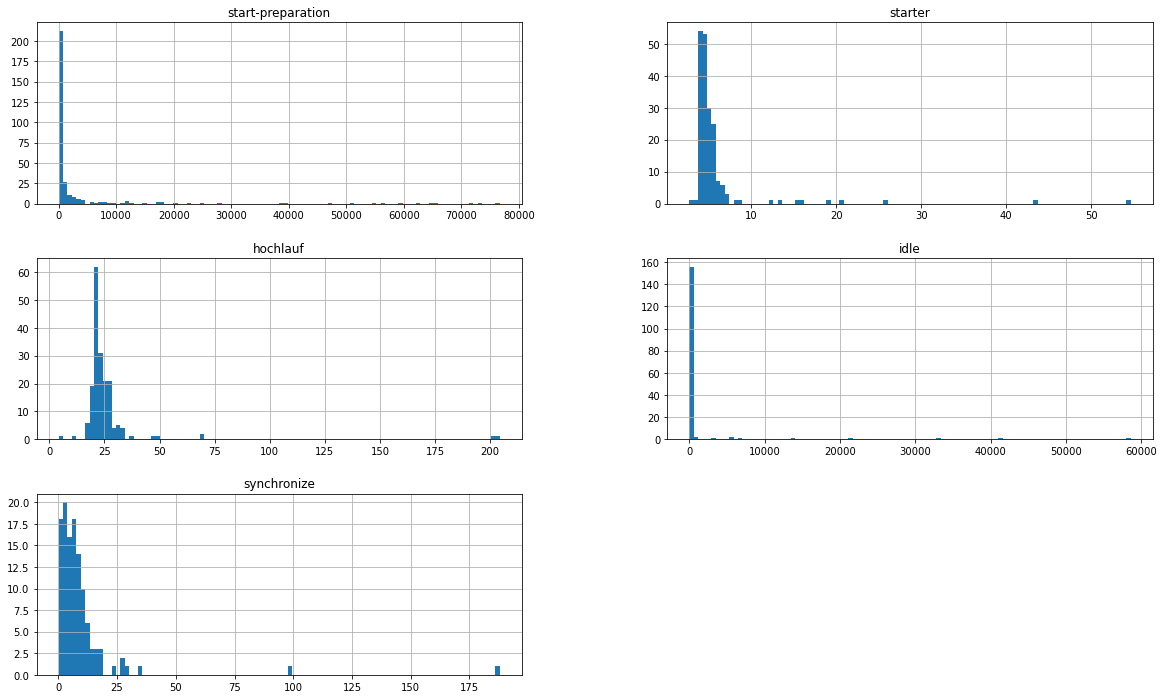

In [7]:
rda[['start-preparation','starter','hochlauf','idle','synchronize']].hist(figsize = (20,12), bins=100);

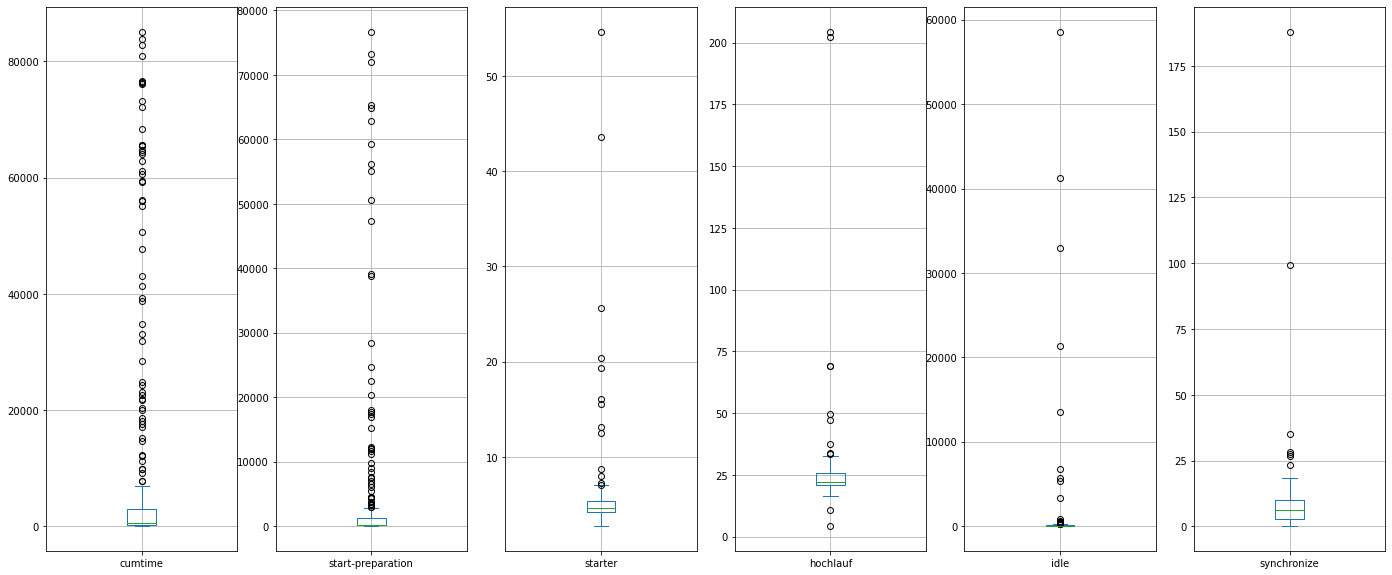

In [8]:
rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,6));

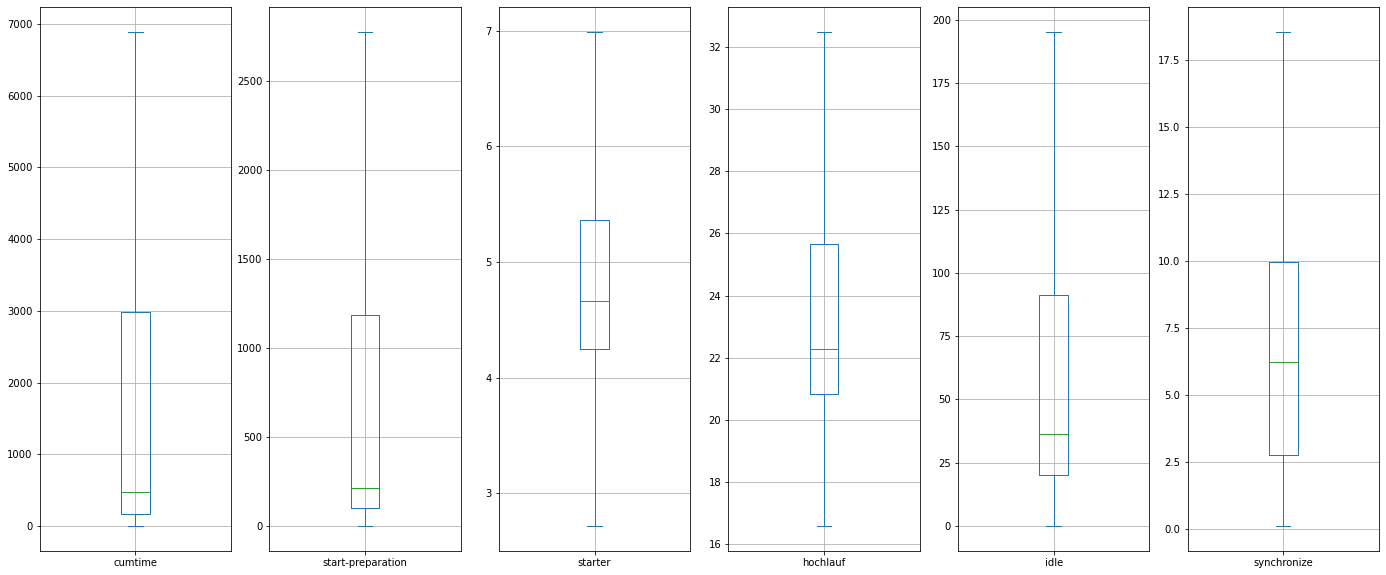

In [9]:
rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,6), sym='');

In [10]:
round((rdf[rdf.success].shape[0] / rdf.shape[0]) * 100,1)

38.4

<Figure size 432x288 with 0 Axes>

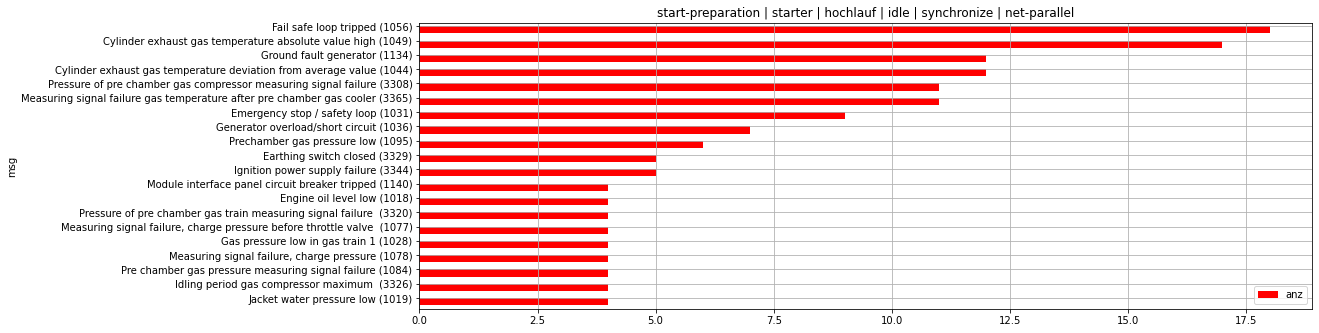

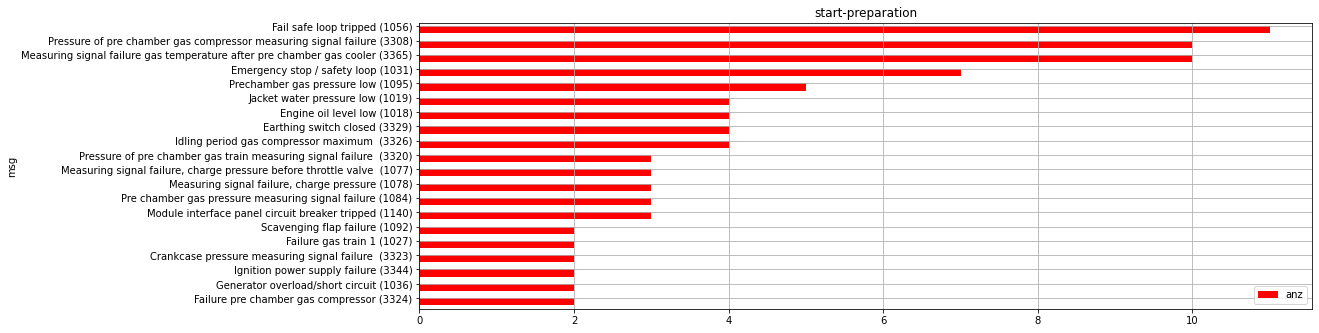

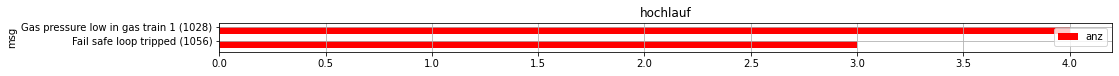

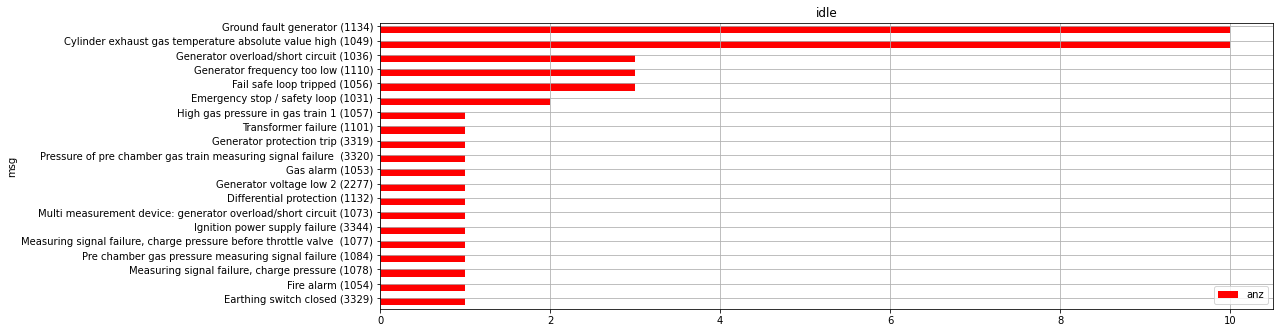

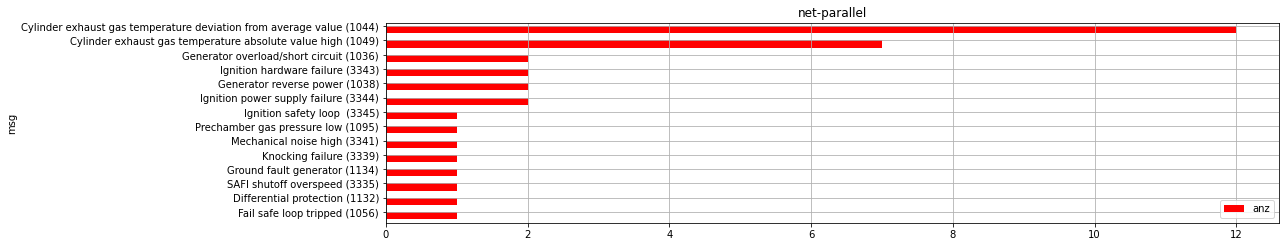

In [11]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','net-parallel'],'start-preparation','starter','hochlauf','idle','synchronize','net-parallel']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:20]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


<Figure size 432x288 with 0 Axes>

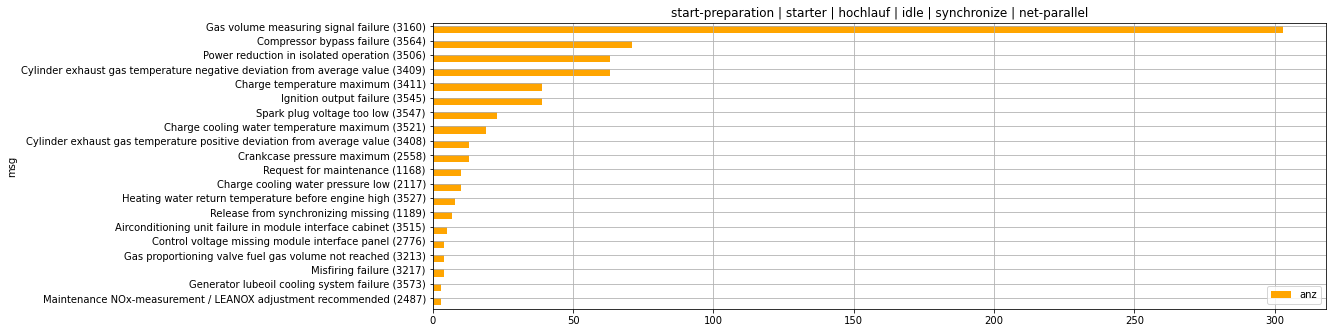

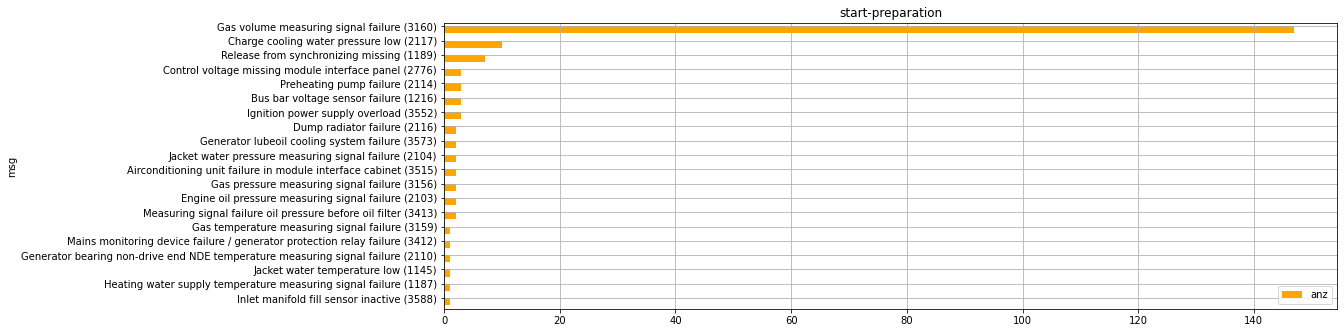

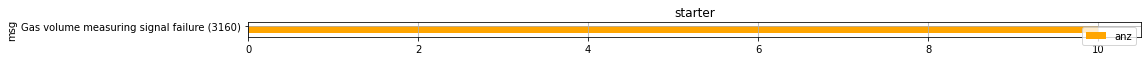

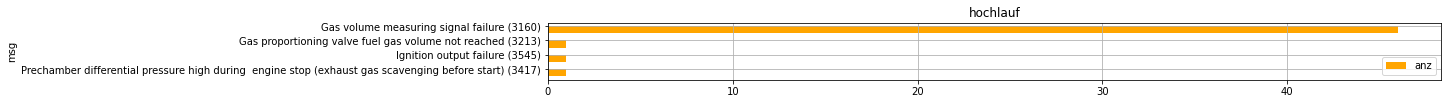

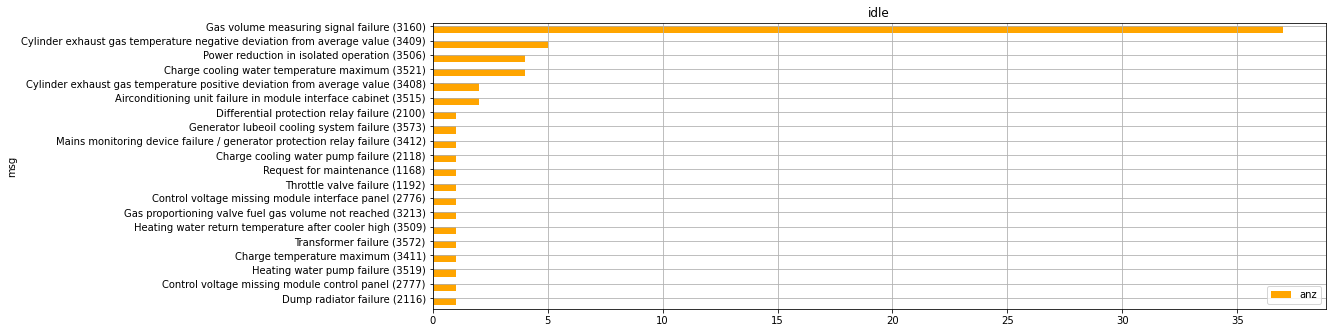

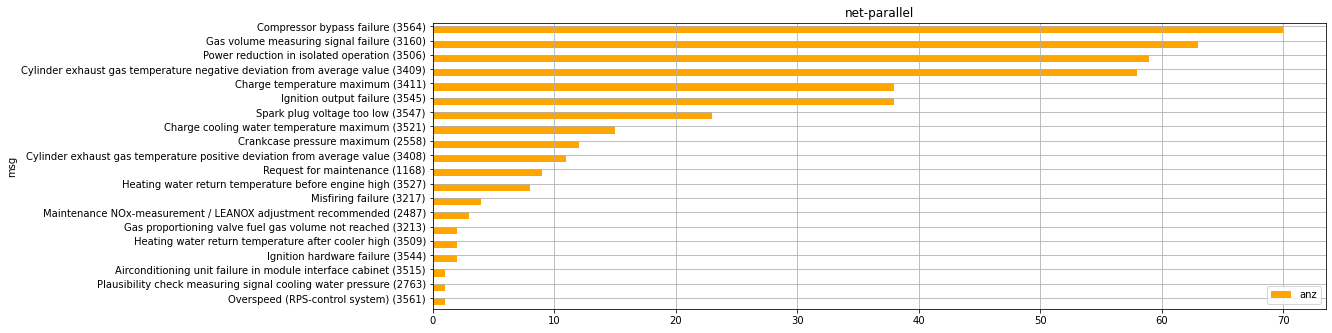

In [12]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','net-parallel'],'start-preparation','starter','hochlauf','idle','synchronize','net-parallel']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:20]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
#fsm.save_messages('msg3.txt')

In [13]:
fsm.store()